In [142]:
import warnings

warnings.filterwarnings(action='ignore')

import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from forest_cover_change_detection.dataloaders.change import ChangeDetectionDataset
from forest_cover_change_detection.models.fc_siam import FCSiam
from forest_cover_change_detection.trainer.train import Compile
from forest_cover_change_detection.metrics.accuracy import *

### Loading Data

In [97]:
data_set = ChangeDetectionDataset('../../data/annotated',
                                  '../../data/train.csv',
                                  concat=False,
                                  patched=False
                                  )

In [98]:
len(data_set)

334

torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([256, 256])


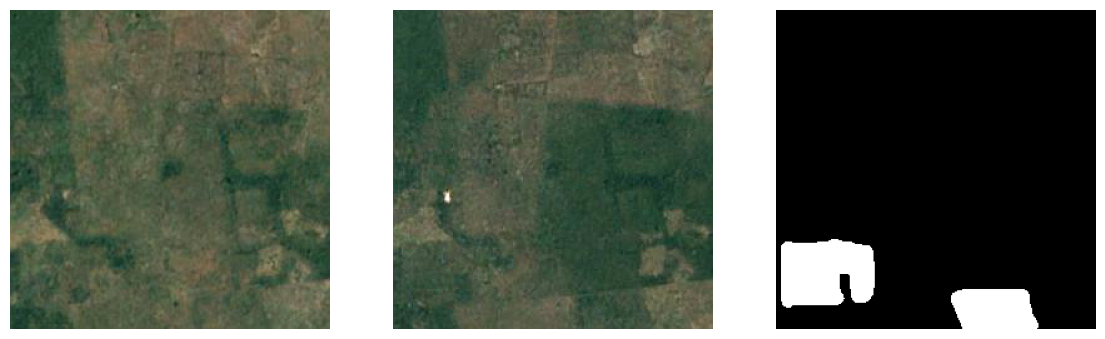

In [6]:
imgs, label = data_set[np.random.randint(0, data_set.__len__())]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 8), dpi=100)
axes = axes.ravel()

axes[0].imshow(imgs[0].permute(1, 2, 0).numpy())
axes[1].imshow(imgs[1].permute(1, 2, 0).numpy())
axes[2].imshow(label.numpy(), cmap='gray')

axes[0].axis(False)
axes[1].axis(False)
axes[2].axis(False)

print(imgs[0].shape, imgs[1].shape, label.shape)

In [99]:
train_size = int(len(data_set) * 0.8)
test_size = len(data_set) - train_size

train_dataset, test_dataset = random_split(data_set, (train_size, test_size))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

len(train_dataloader), len(test_dataloader)

(9, 3)

### Modeling

In [8]:
model = FCSiam(3, classes=2, diff=False)

In [9]:
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, cooldown=10)
# scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=50)

compiled = Compile(model,
                   optimizer,
                   lr_scheduler=scheduler
                   )

In [32]:
compiled.summary([(3, 256, 256), (3, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
           Dropout-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
           Dropout-6         [-1, 16, 256, 256]               0
         MaxPool2d-7         [-1, 16, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]           4,640
       BatchNorm2d-9         [-1, 32, 128, 128]              64
          Dropout-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]           9,248
      BatchNorm2d-12         [-1, 32, 128, 128]              64
          Dropout-13         [-1, 32, 128, 128]               0
        MaxPool2d-14           [-1, 32,


(dot.exe:23020): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


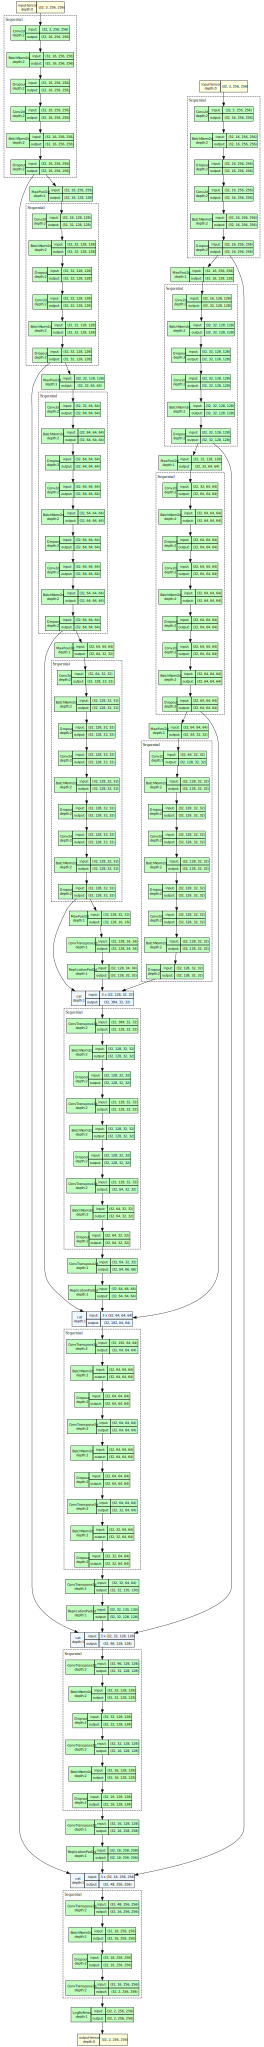

In [33]:
compiled.visual_graph([(32, 3, 256, 256), (32, 3, 256, 256)])

In [10]:
w = torch.load('../../data/class_weight.pt')
w

tensor([0.0962, 1.9038], device='cuda:0')

In [11]:
# torch.FloatTensor([0.0962, 0.2]).cuda()

results = compiled.train(train_dataloader,
                         nn.NLLLoss(w),
                         100,
                         test_dataloader,
                         multi_in=True
                         )

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100
train loss: 0.7468559338765985
val loss: 0.9784227344724867
Epoch: 1/100
train loss: 0.6419773154398974
val loss: 0.6528405083550347
Epoch: 2/100
train loss: 0.633781794239493
val loss: 0.6839135686556498
Epoch: 3/100
train loss: 0.6061862935038174
val loss: 0.707350922955407
Epoch: 4/100
train loss: 0.6043885578127468
val loss: 0.5580309927463531
Epoch: 5/100
train loss: 0.5769729982404148
val loss: 0.6875763038794199
Epoch: 6/100
train loss: 0.5815787289072486
val loss: 0.5563110046916537
Epoch: 7/100
train loss: 0.5655011429506189
val loss: 0.5368021229902903
Epoch: 8/100
train loss: 0.5527021963806713
val loss: 0.5999288327164121
Epoch: 9/100
train loss: 0.5537659026244107
val loss: 0.5569242470794253
Epoch: 10/100
train loss: 0.5500276895130382
val loss: 0.5747718214988708
Epoch: 11/100
train loss: 0.5395796272684547
val loss: 0.5282893710666232
Epoch: 12/100
train loss: 0.5373205533799004
val loss: 0.575540628698137
Epoch: 13/100
train loss: 0.5392786290715722
val lo

In [79]:
# restore best checkpoint
state = torch.load("./last-checkpoint.pth")
model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

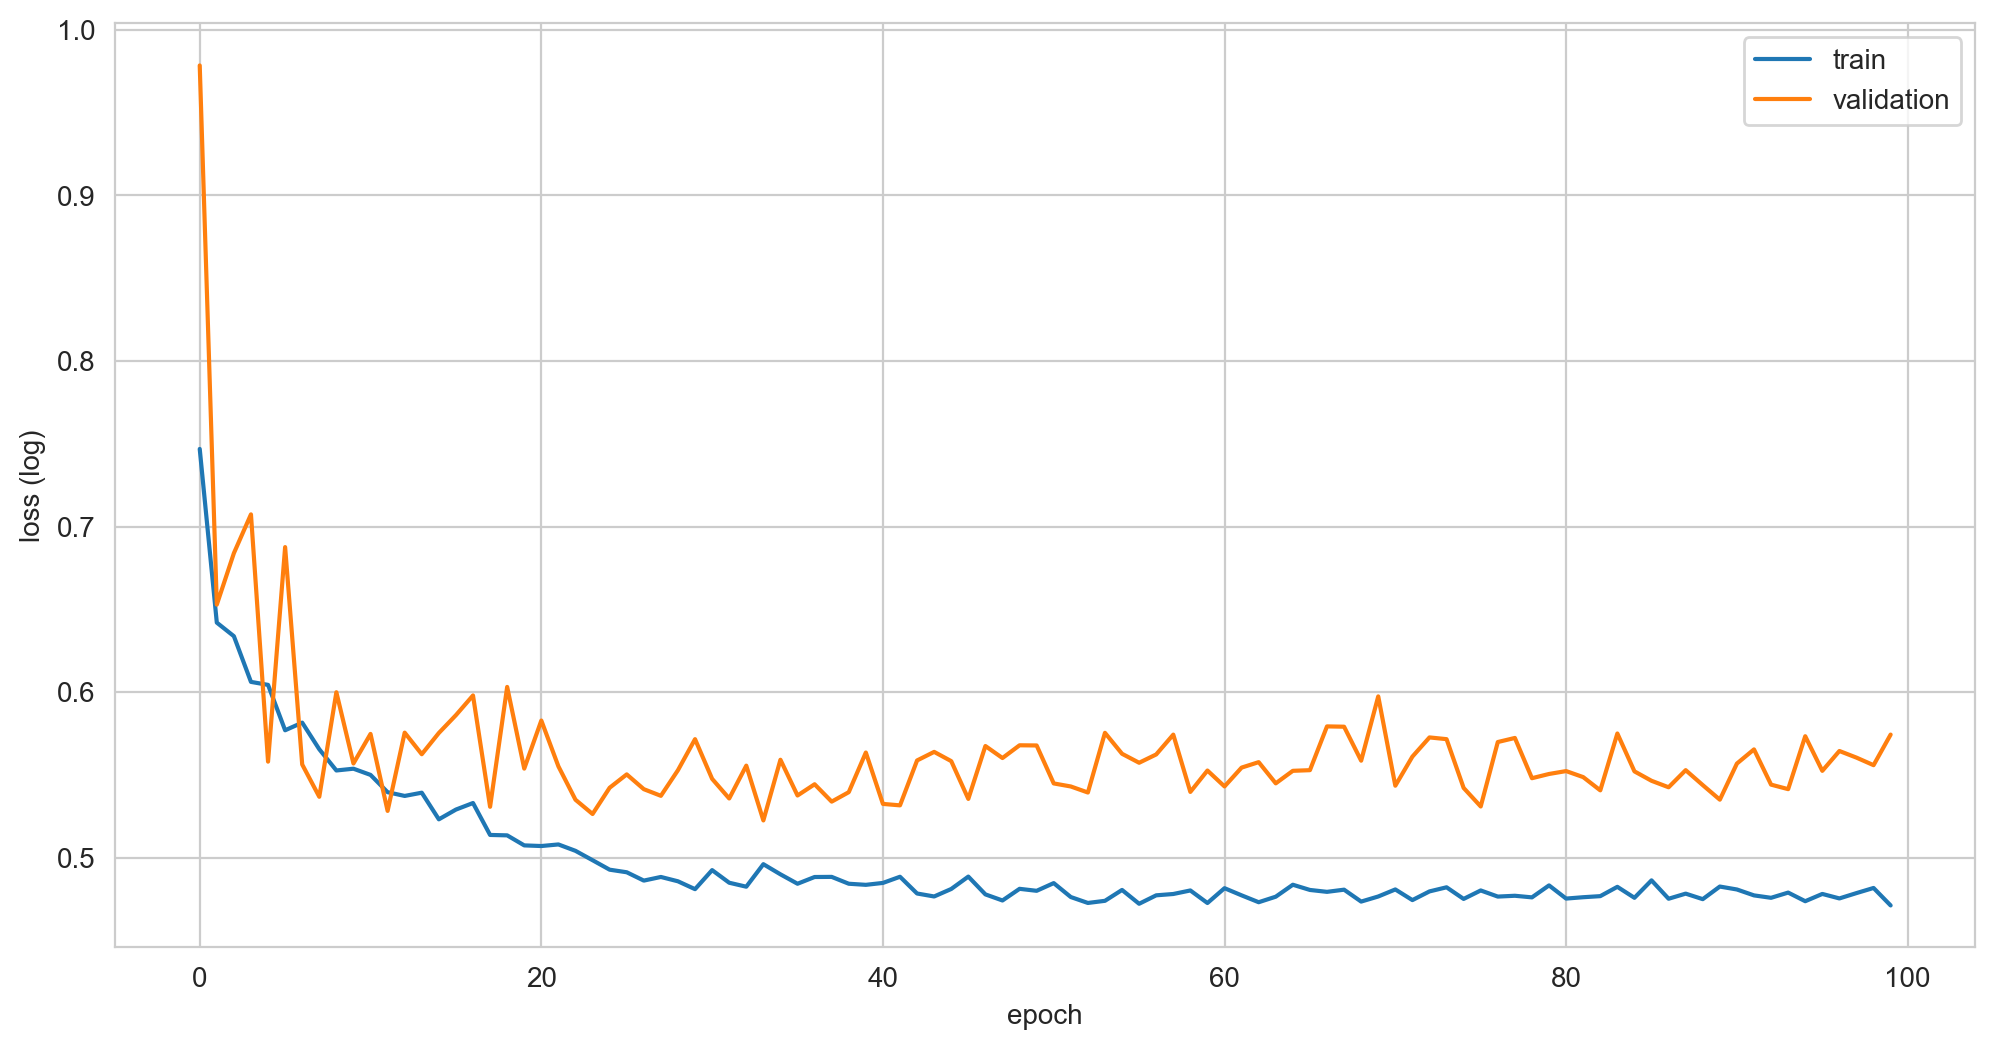

In [12]:
plt.figure(figsize=(12, 6), dpi=200)
sns.lineplot(x=results['epoch'], y=results['train loss'], label='train')
sns.lineplot(x=results['epoch'], y=results['val loss'], label='validation')
plt.ylabel('loss (log)')
plt.show()

In [231]:
df = pd.read_csv('../../data/annotated/train.csv')

In [260]:
acc_test = []
change_acc = []
no_change_acc = []
p = []
r = []
d = []
k = []
metrics = pd.DataFrame()

for i, row in tqdm(df.iterrows()):
    img, gt = (read_image(f'../../data/annotated/{row.dir}/{row.img_1}'),
               read_image(f'../../data/annotated/{row.dir}/{row.img_2}')), read_image(
        f'../../data/annotated/{row.label}')

    img1 = resize(img[0], size=[256, 256]) / 255.0
    img2 = resize(img[1], size=[256, 256]) / 255.0
    gt = resize(gt, size=[256, 256]).squeeze(0) / 255.0

    with torch.no_grad():
        model.eval()
        logits = model(img1.unsqueeze(0).to('cuda'),
                       img2.unsqueeze(0).to('cuda'))[0].cpu()
        pred = torch.argmax(torch.sigmoid(logits), dim=0)

    class_acc = class_accuracy(gt, logits)

    acc_test.append(pixel_accuracy(gt, pred).numpy().tolist())
    p.append(precision(gt, pred).numpy().tolist())
    r.append(recall(gt, pred).numpy().tolist())
    d.append(dice(gt, pred).numpy().tolist())
    k.append(kappa(gt, pred).numpy().tolist())
    no_change_acc.append(class_acc[0])
    change_acc.append(class_acc[1])

metrics['overall accuracy'] = acc_test
metrics['change accuracy'] = change_acc
metrics['no change accuracy'] = no_change_acc
metrics['precision'] = p
metrics['recall'] = r
metrics['dice'] = d
metrics['kappa'] = k

0it [00:00, ?it/s]

In [262]:
metrics.mean()

overall accuracy      0.917673
change accuracy       0.302178
no change accuracy    0.949283
precision             0.301433
recall                0.269461
dice                  0.252344
kappa                 0.193912
dtype: float64

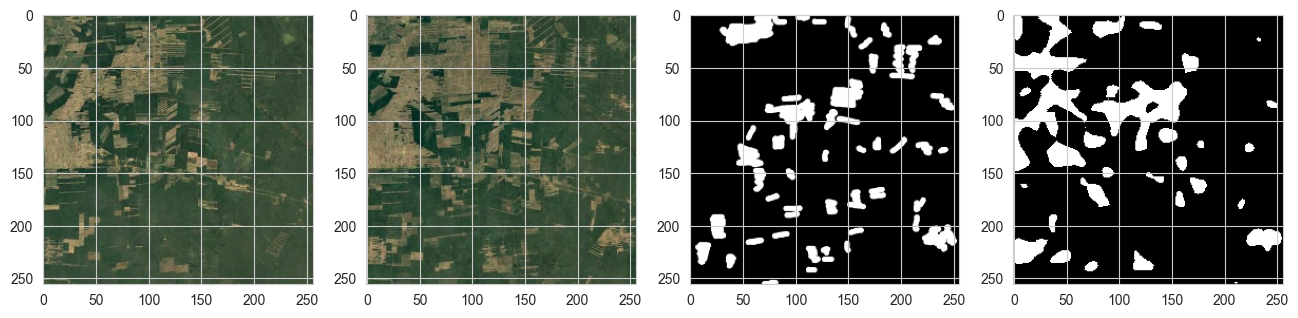

In [258]:
sample = pd.read_csv('../../data/annotated/train.csv').sample(1)
img, gt = (read_image(f'../../data/annotated/{sample.dir.values[0]}/{sample.img_1.values[0]}'),
           read_image(f'../../data/annotated/{sample.dir.values[0]}/{sample.img_2.values[0]}')), read_image(
    f'../../data/annotated/{sample.label.values[0]}')

img1 = resize(img[0], size=[256, 256]) / 255.0
img2 = resize(img[1], size=[256, 256]) / 255.0
gt = resize(gt, size=[256, 256]).squeeze(0) / 255.0

with torch.no_grad():
    model.eval()
    logits = model(img1.unsqueeze(0).to('cuda'),
                   img2.unsqueeze(0).to('cuda'))[0].cpu()
    pred = torch.argmax(torch.sigmoid(logits), dim=0)

plt.figure(figsize=(16, 10))
plt.subplot(1, 4, 1)
plt.imshow(img1.permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(gt, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(img2.permute(1, 2, 0), cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(pred, cmap='gray')

In [259]:
pixel_accuracy(gt, pred), precision(gt, pred), recall(gt, pred), dice(gt, pred), kappa(gt, pred), class_accuracy(gt, pred)

(tensor(0.8042),
 tensor(0.3522),
 tensor(0.3859),
 tensor(0.3683),
 tensor(0.2528),
 [0.1933833211660385, 0.0005956813110969961])